# Lab 2: Building a Modeling Data Set

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

In this lab, you will complete the following tasks to <b>build a modeling data set</b>:

1. <b>Load the Airbnb "listings" data set</b> and identify the <b>number of rows & columns</b>
2. <b>Remove features</b> that are not currently useful for analysis; <br>
<b>Modify features</b> to make sure they are machine-comprehensible
3. Build a new regression <b>label column</b> by winsorizing outliers
4. Replace all <b>missing values</b> with means
5. <b>Identify</b> two features with the <b>highest correlation with the label</b>
6. Build appropriate <b>bivariate plots</b> between the highest correlated features and the label


## Part 1. Load the Data

We will once again be working with the Airbnb NYC "listings" data set. Use the specified path and name of the file to load the data. Save it as a Pandas DataFrame called `df`.

In [2]:
# Do not remove or edit the line below:
filename = os.path.join(os.getcwd(), "data", "listings.csv.gz")

**Task**: load the data and save it to DataFrame `df`.

In [3]:
df = pd.read_csv(filename, header = 0, low_memory = False)

<b>Task</b>: Display the shape of `df` -- that is, the number of rows and columns.

In [4]:
df.shape

(38277, 74)

**Task**: Get a peek at the data by displaying the first few rows, as you usually do.

In [5]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20211204143024,2021-12-05,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,4.79,4.86,4.41,NaN,f,3,3,0,0,0.33
1,3831,https://www.airbnb.com/rooms/3831,20211204143024,2021-12-05,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,...,4.80,4.71,4.64,NaN,f,1,1,0,0,4.86
2,5121,https://www.airbnb.com/rooms/5121,20211204143024,2021-12-05,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,...,4.91,4.47,4.52,NaN,f,2,0,2,0,0.52
3,5136,https://www.airbnb.com/rooms/5136,20211204143024,2021-12-05,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,...,5.00,4.50,5.00,NaN,f,1,1,0,0,0.02
4,5178,https://www.airbnb.com/rooms/5178,20211204143024,2021-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,...,4.42,4.87,4.36,NaN,f,1,0,1,0,3.68


## Part 2. Feature Selection and Engineering

We won't need the data fields that contain free, unstructured text. For example, we wont need the columns that contain apartment descriptions supplied by the host, customer reviews, or descriptions of the neighborhoods in which a listing is located.

The code cell below contains a list containing the names of *unstructured text* columns.<br>


In [6]:
unstr_text_colnames = ['description', 'name', 'neighborhood_overview', 'host_about', 'host_name', 'host_location']

**Task**: Drop the columns with the specified names, *in place* (that is, make sure this change applies to the original DataFrame `df`, instead of creating a temporary new DataFrame with fewer columns).

In [7]:
df.drop(unstr_text_colnames, axis = 1, inplace = True)

**Task**: Display the shape of the data to verify that the new number of columns is what you expected.

In [8]:
df.shape

(38277, 68)

We will furthermore get rid of all the columns which contain webpage addresses (URLs).<br>

**Task**: Create a list which contains the names of columns that contain URLs.<br> Save the resulting list to variable `url_colnames`.

*Tip*: There are different ways to accomplish this, including using Python list comprehensions

In [9]:
url_colnames = []
for col in df.columns:
    if 'url' in col:
        url_colnames.append(col)
url_colnames
    

['listing_url',
 'picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url']

**Task**: Drop the columns with the specified names contained in list `url_colnames` in place (that is, make sure this change applies to the original DataFrame `df`, instead of creating a temporary new DataFrame object with fewer columns).

In [10]:
df.drop(url_colnames, axis = 1, inplace = True)

**Task**: Another property of this dataset is that the `price` column contains values that are listed as <br>$<$currency_name$>$$<$numeric_value$>$. For example, it contains values that look like this: `$120`. <br>

Let's look at the first 15 unique values of this column.<br>

Display the first 15 unique values of  the `price` column:

In [11]:
df['price'].unique()[:15]

array(['$150.00', '$75.00', '$60.00', '$275.00', '$68.00', '$98.00',
       '$89.00', '$65.00', '$62.00', '$90.00', '$199.00', '$96.00',
       '$299.00', '$140.00', '$175.00'], dtype=object)

In order for us to use the prices for modeling, we will have to transform all values of this `price` feature into regular floats.<br>
We will first need to remove the dollar signs (in this case, the platform forces the currency to be the USD, so we do not need to worry about targeting, say, the Japanese Yen sign, nor about converting the values into USD). Furthermore, we need to remove commas from all values that are in the thousands or above: for example, `$2,500$`. Here is how to do both:

In [188]:
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].astype(float)

Let's display the first few unique values again, to make sure they are transformed:

In [189]:
df['price'].unique()[:15]

array([150.,  75.,  60., 275.,  68.,  98.,  89.,  65.,  62.,  90., 199.,
        96., 299., 140., 175.])

Well done! Our transformed dataset looks like this:

In [190]:
df.head()

,id,scrape_id,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,20211204143024,2021-12-05,2845,2008-09-09,within a day,80%,17%,f,Midtown,...,4.79,4.86,4.41,NaN,f,3,3,0,0,0.33
1,3831,20211204143024,2021-12-05,4869,2008-12-07,a few days or more,9%,69%,f,Clinton Hill,...,4.80,4.71,4.64,NaN,f,1,1,0,0,4.86
2,5121,20211204143024,2021-12-05,7356,2009-02-03,within an hour,100%,100%,f,Bedford-Stuyvesant,...,4.91,4.47,4.52,NaN,f,2,0,2,0,0.52
3,5136,20211204143024,2021-12-05,7378,2009-02-03,within a day,100%,25%,f,Greenwood Heights,...,5.00,4.50,5.00,NaN,f,1,1,0,0,0.02
4,5178,20211204143024,2021-12-05,8967,2009-03-03,within a day,100%,100%,f,Hell's Kitchen,...,4.42,4.87,4.36,NaN,f,1,0,1,0,3.68


## Part 3. Create a (Winsorized) Label Column

Assume that your goal is to use this dataset to fit a regression model that predicts the price under which a given space is listed.

**Task**: Create a new version of the `price` column, named `label_price`, in which we replace the top and bottom 1% outlier values with the corresponding percentile value. Add this new column to the DataFrame `df`.

Remember, you will first need to load the `stats` module from the `scipy` package:

In [191]:
import scipy.stats as stats
label_price = stats.mstats.winsorize(df['price'], limits=[.01,.01])

In [192]:
df.loc[:,'label_price'] = label_price

Let's verify that a new column got added to the DataFrame:

In [193]:
df.head()

,id,scrape_id,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,label_price
0,2595,20211204143024,2021-12-05,2845,2008-09-09,within a day,80%,17%,f,Midtown,...,4.86,4.41,NaN,f,3,3,0,0,0.33,150.0
1,3831,20211204143024,2021-12-05,4869,2008-12-07,a few days or more,9%,69%,f,Clinton Hill,...,4.71,4.64,NaN,f,1,1,0,0,4.86,75.0
2,5121,20211204143024,2021-12-05,7356,2009-02-03,within an hour,100%,100%,f,Bedford-Stuyvesant,...,4.47,4.52,NaN,f,2,0,2,0,0.52,60.0
3,5136,20211204143024,2021-12-05,7378,2009-02-03,within a day,100%,25%,f,Greenwood Heights,...,4.50,5.00,NaN,f,1,1,0,0,0.02,275.0
4,5178,20211204143024,2021-12-05,8967,2009-03-03,within a day,100%,100%,f,Hell's Kitchen,...,4.87,4.36,NaN,f,1,0,1,0,3.68,68.0


**Task**: Check that the values of `price` and `label_price` are *not* identical. Do this by subtracting the two columns and printing the *length* of the array (using the `len()` function) of *unique values* of the resulting difference. <br>Note: If all values are identical, the difference would contain only one unique value -- zero. If this is the case, outlier removal did not work.

In [194]:
unique_values = (df['price']-df['label_price']).unique()
length = len(unique_values)
print (length)

206


## Part 4. Replace the Missing Values With Means

### a. Identifying missingness

**Task**: Check if a given value in any data cell is missing, and sum up the resulting values (`True`/`False`) by columns. Save this sum to variable `nan_count`. Print the results.

In [195]:
nan_count = np.sum(df.isnull(), axis = 0)
nan_count

id                                                 0
scrape_id                                          0
last_scraped                                       0
host_id                                            0
host_since                                        34
                                                ... 
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               9504
label_price                                        0
Length: 64, dtype: int64

Those are more columns than we can eyeball! For this exercise, we don't care about the number of missing values -- we just want to get a list of columns that have *any*. <br>

<b>Task</b>: From variable `nan_count`, create a new series called `nan_detected` that contains `True`/`False` values that indicate whether the number of missing values is *not zero*:

In [196]:
nan_detected = nan_count!=0
nan_detected

id                                              False
scrape_id                                       False
last_scraped                                    False
host_id                                         False
host_since                                       True
                                                ...  
calculated_host_listings_count_entire_homes     False
calculated_host_listings_count_private_rooms    False
calculated_host_listings_count_shared_rooms     False
reviews_per_month                                True
label_price                                     False
Length: 64, dtype: bool

Since replacing the missing values with the mean only makes sense for the numerically valued columns (and not for strings, for example), let us create another condition: the *type* of the column must be `int` or `float`.

**Task**: Create a series that contains `True` if the type of the column is either `int64` or `float64`. Save the result to variable `is_int_or_float`.

In [197]:
is_int_or_float = (df.dtypes == 'int64') | (df.dtypes == 'float64')
is_int_or_float

id                                               True
scrape_id                                        True
last_scraped                                    False
host_id                                          True
host_since                                      False
                                                ...  
calculated_host_listings_count_entire_homes      True
calculated_host_listings_count_private_rooms     True
calculated_host_listings_count_shared_rooms      True
reviews_per_month                                True
label_price                                      True
Length: 64, dtype: bool

<b>Task</b>: Combine the two binary series values into a new series named `to_impute`. It will contain the value `True` if a column contains missing values *and* is of type 'int' or 'float'

In [198]:
to_impute = nan_detected & is_int_or_float
to_impute

id                                              False
scrape_id                                       False
last_scraped                                    False
host_id                                         False
host_since                                      False
                                                ...  
calculated_host_listings_count_entire_homes     False
calculated_host_listings_count_private_rooms    False
calculated_host_listings_count_shared_rooms     False
reviews_per_month                                True
label_price                                     False
Length: 64, dtype: bool

Finally, let's display a list that contains just the selected column names:

In [199]:
df.columns[to_impute]

Index(['host_listings_count', 'host_total_listings_count', 'bathrooms',
       'bedrooms', 'beds', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

We just identified and displayed the list of candidate columns for potentially replacing missing values with the column mean.

Assume that you have decided that it is safe to impute the values for `host_listings_count`, `host_total_listings_count`, `bathrooms`, `bedrooms`, and `beds`:

In [200]:
to_impute_selected = ['host_listings_count', 'host_total_listings_count', 'bathrooms',
       'bedrooms', 'beds']

### b. Keeping record of the missingness: creating dummy variables 

As a first step, you will now create dummy variables indicating missingness of the values.

**Task**: Store the `True`/`False` series that indicate missingness of any value in a given column as a new variable called<br> `<original-column-name>_na`. 

In [201]:
for colname in to_impute_selected:
    colname_na = colname + '_na'
    df[colname_na] = df[colname].isnull()

Check that the DataFrame contains the new variables:

In [202]:
df.head()

,id,scrape_id,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,label_price,host_listings_count_na,host_total_listings_count_na,bathrooms_na,bedrooms_na,beds_na
0,2595,20211204143024,2021-12-05,2845,2008-09-09,within a day,80%,17%,f,Midtown,...,3,0,0,0.33,150.0,False,False,True,True,False
1,3831,20211204143024,2021-12-05,4869,2008-12-07,a few days or more,9%,69%,f,Clinton Hill,...,1,0,0,4.86,75.0,False,False,True,False,False
2,5121,20211204143024,2021-12-05,7356,2009-02-03,within an hour,100%,100%,f,Bedford-Stuyvesant,...,0,2,0,0.52,60.0,False,False,True,False,False
3,5136,20211204143024,2021-12-05,7378,2009-02-03,within a day,100%,25%,f,Greenwood Heights,...,1,0,0,0.02,275.0,False,False,True,False,False
4,5178,20211204143024,2021-12-05,8967,2009-03-03,within a day,100%,100%,f,Hell's Kitchen,...,0,1,0,3.68,68.0,False,False,True,False,False


### c. Replacing the missing values with mean values of the column

**Task**: Fill the missing values of the selected few columns with the corresponding mean value.

In [203]:
for colname in to_impute_selected:
    mean = df[colname].mean()
    df[colname].fillna(value=mean, inplace=True)

Check your results below. The code displayes the count of missing values for each of the selected columns. 

In [204]:
for colname in to_impute_selected:
    print("{} missing values count :{}".format(colname, np.sum(df[colname].isnull(), axis = 0)))


host_listings_count missing values count :0
host_total_listings_count missing values count :0
bathrooms missing values count :38277
bedrooms missing values count :0
beds missing values count :0


Why did the `bathrooms` column retain missing values after our imputation?

**Task**: List the unique values of the `bathrooms` column.

In [205]:
df['bathrooms'].unique()

array([nan])

The column did not contain a single value (except the `NaN` indicator) to begin with.

## Part 5. Identify Features With the Highest Correlation With the Label

Your next goal is to figure out which features in the data correlate most with the label.<br>

In the next few cells, we will demonstrate how to use the Pandas `corr()` method to get a list of correlation coefficients between `label` and all other (numerical) features.

Let's first glance at what the `corr()` method does:

In [206]:
df.corr().head()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,label_price,host_listings_count_na,host_total_listings_count_na,bathrooms_na,bedrooms_na,beds_na
id,1.000000e+00,-4.269620e-13,5.861676e-01,1.298621e-01,1.298621e-01,1.000083e-02,8.708041e-02,3.540148e-02,NaN,4.502641e-02,...,1.371325e-01,2.118813e-01,4.671123e-02,2.316854e-01,7.906593e-02,-8.301146e-03,-8.301146e-03,NaN,3.342643e-02,1.363999e-01
scrape_id,-4.269620e-13,1.000000e+00,2.367225e-13,-2.061273e-14,-2.061273e-14,7.448373e-13,-1.544987e-11,1.251408e-14,NaN,1.094740e-13,...,2.212092e-14,-4.315383e-14,-9.152507e-15,5.899236e-15,-3.138348e-14,-3.883529e-15,-3.883529e-15,NaN,1.922869e-15,-4.177378e-14
host_id,5.861676e-01,2.367225e-13,1.000000e+00,3.189206e-02,3.189206e-02,4.148254e-02,1.162017e-01,2.722884e-02,NaN,2.201904e-02,...,2.524284e-02,1.931984e-01,7.830736e-02,2.084392e-01,4.053291e-02,-3.707217e-03,-3.707217e-03,NaN,3.354441e-02,9.217727e-02
host_listings_count,1.298621e-01,-2.061273e-14,3.189206e-02,1.000000e+00,1.000000e+00,3.475008e-02,-8.842627e-02,-2.620826e-02,NaN,-1.709828e-02,...,5.418772e-01,1.491464e-01,-1.594956e-02,-2.095984e-02,1.310429e-01,-1.234737e-15,-1.234737e-15,NaN,1.296648e-02,-1.032184e-02
host_total_listings_count,1.298621e-01,-2.061273e-14,3.189206e-02,1.000000e+00,1.000000e+00,3.475008e-02,-8.842627e-02,-2.620826e-02,NaN,-1.709828e-02,...,5.418772e-01,1.491464e-01,-1.594956e-02,-2.095984e-02,1.310429e-01,-1.234737e-15,-1.234737e-15,NaN,1.296648e-02,-1.032184e-02


The result is a computed *correlation matrix*. The values on the diagonal are all equal to 1, and the matrix is symmetrical with respect to the diagonal (note that we are only printing the first five lines of it).<br>

We only need to observe correlations of all features with *the label* (as opposed to every possible pairwise correlation). <br>

**Task**: Save the `label_price` column of the correlation matrix to the variable `corrs`:

In [207]:
corrs = df.corr()['label_price']
corrs

id                                              7.906593e-02
scrape_id                                      -3.138348e-14
host_id                                         4.053291e-02
host_listings_count                             1.310429e-01
host_total_listings_count                       1.310429e-01
latitude                                        4.329905e-02
longitude                                      -2.069501e-01
accommodates                                    5.006227e-01
bathrooms                                                NaN
bedrooms                                        4.199613e-01
beds                                            3.736971e-01
price                                           7.111249e-01
minimum_nights                                 -7.589208e-02
maximum_nights                                 -9.728756e-04
minimum_minimum_nights                         -3.803776e-02
maximum_minimum_nights                          6.553784e-02
minimum_maximum_nights  

**Task**: Sort the values of the series we just obtained in the descending order.

In [208]:
corrs_sorted = corrs.sort_values(axis = 0, ascending = False)
corrs_sorted

label_price                                     1.000000e+00
price                                           7.111249e-01
accommodates                                    5.006227e-01
bedrooms                                        4.199613e-01
beds                                            3.736971e-01
availability_60                                 1.470082e-01
availability_30                                 1.456894e-01
availability_90                                 1.439066e-01
host_listings_count                             1.310429e-01
host_total_listings_count                       1.310429e-01
availability_365                                1.235559e-01
maximum_maximum_nights                          1.116868e-01
review_scores_location                          9.724051e-02
calculated_host_listings_count_entire_homes     9.508782e-02
review_scores_cleanliness                       8.254405e-02
maximum_nights_avg_ntm                          8.209898e-02
id                      

**Task**: In the code cell below, save the *column names* for the top-2 correlation values to the list `top_two_corr` (not counting the correlation of `label` column with itself, nor the `price` column -- which is the `label` column prior to outlier removal). Add the column names to the list in the order in which they appear in the output above. <br>
Tip: `corrs_sorted` is a Pandas `Series` object, in which column names are the *index*.

In [217]:
top_two_corr = list(corrs_sorted.index[2:4])
top_two_corr

['accommodates', 'bedrooms']

## Part 6. Produce Bivariate Plots for the Label and Its Top Correlates

We will use the `pairplot()` function in `seaborn` to plot the relationships between the two features we identified and the label.

**Task**: Create a DataFrame `df_sub` that contains only the selected three columns: the label, and the two columns which correlate with it the most.

In [218]:
# Do not remove or edit the line below:
top_two_corr.append('label_price')


df_sub = df[top_two_corr]
df_sub.head()

,accommodates,bedrooms,label_price
0,1,1.323567,150.0
1,3,1.000000,75.0
2,2,1.000000,60.0
3,4,2.000000,275.0
4,2,1.000000,68.0


**Task**: Create a `seaborn` pairplot of the data subset you just created

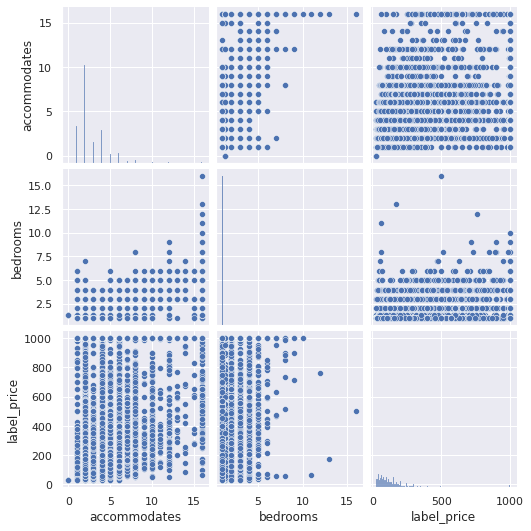

In [219]:
sns.pairplot(df_sub)

This one is not very easy to make sense of: the points overlap, but we do not have visibility into how densely they are stacked together.
<br>

**Task**: Repeat the `pairplot` exercise, this time specifying the *kernel density estimator* as the *kind* of the plot.<br>
    Tip: use `kind = 'kde'` as a parameter of the `pairplot()` function. You could also specify `corner=True` to make sure you don't plot redundant (symmetrical) plots.
   <br>
   Note: this one may take a while!

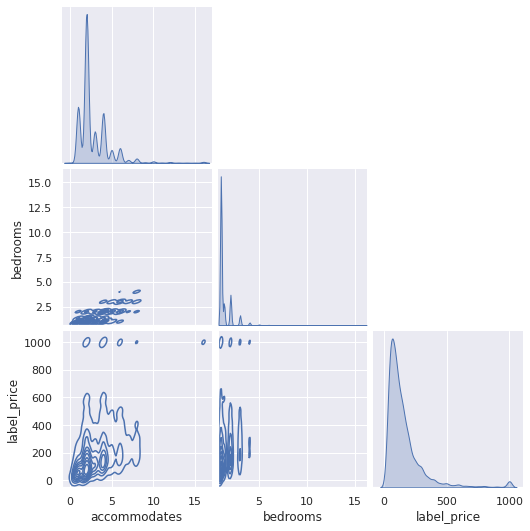

In [220]:
sns.pairplot(df_sub, kind = 'kde', corner = True)